## Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## References
https://www.kaggle.com/code/wti200/analysing-interactions-with-shap issued by ***@WTI200***<br>
https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense/notebook issued by ***@AMBROSM***

## Blue print

0. Import relevant packages
1. Load data and split into training and validating set
2. Investigate training set
- Numeric data
- String data
3. Preprocess training, validating and testing set
4. Apply ML models

## 0. Import Packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# We want to see all columns
pd.set_option("display.max_columns", None)

## 1. Data Loading

In [2]:
# Load dataset
train = pd.read_csv('train.csv')
Xte = pd.read_csv('test.csv')

train.shape, Xte.shape

((900000, 33), (700000, 32))

In [3]:
# Check data types and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

**Comments**: There is no null values and only one column (`f_27`) is object values.

In [4]:
# Seperate 'id'; We will use 'test_id' for to format submition file
train_id = train['id']
test_id = Xte['id']

# Drop 'id'
train= train.drop(columns=['id'])
Xte = Xte.drop(columns=['id'])

In [5]:
# Seperate into features and targets
X = train.drop(columns=['target'])  # feature dataframe
Y = train['target']                 # target dataframe

X.shape, Y.shape

((900000, 31), (900000,))

In [6]:
# Split into training and validating set
Xtr, Xva, Ytr, Yva = train_test_split(X, Y, test_size=0.33, random_state=0)

**Comments**: We will proceed furter investigation on the training dataset. But we should not 'peek' the validating dataset. Validating dataset should be treated as unknown.

In [7]:
# Reset indices
Xtr.reset_index(drop=True, inplace=True) 
Xva.reset_index(drop=True, inplace=True)     
Ytr.reset_index(drop=True, inplace=True)
Yva.reset_index(drop=True, inplace=True)

# Update (We don't want to 'peek' the validation set!)
train = pd.concat([Xtr, Ytr], axis=1)

## 2. Data Investigation

### 1) Numeric features

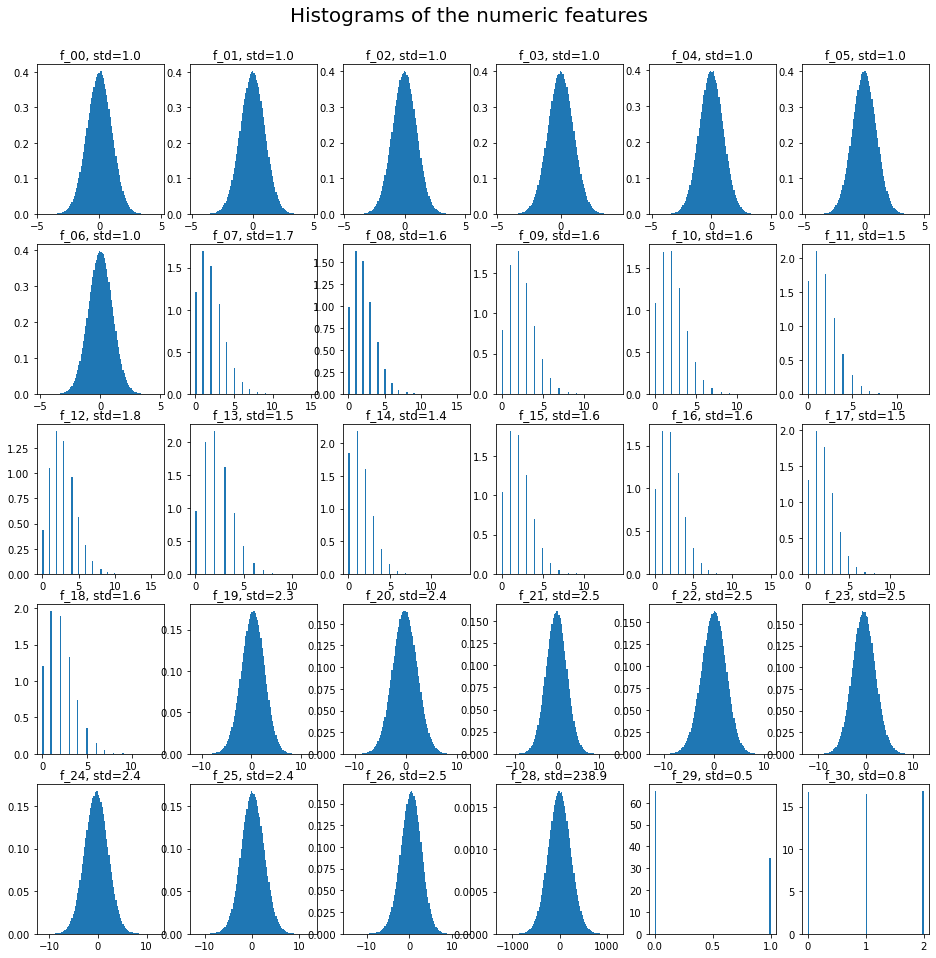

In [8]:
num_features = [c for c in X.columns if (X[c].dtype == 'float64') | (X[c].dtype == 'int64')]

# Check histograms
fig, axs = plt.subplots(5, 6, figsize=(16, 16))
for f, ax in zip(num_features, axs.ravel()):    # paring each feature for each ax
    ax.hist(X[f], density=True, bins=100)
    ax.set_title(f'{f}, std={train[f].std():.1f}')
plt.suptitle('Histograms of the numeric features', y=0.93, fontsize=20)
plt.show()

<AxesSubplot:>

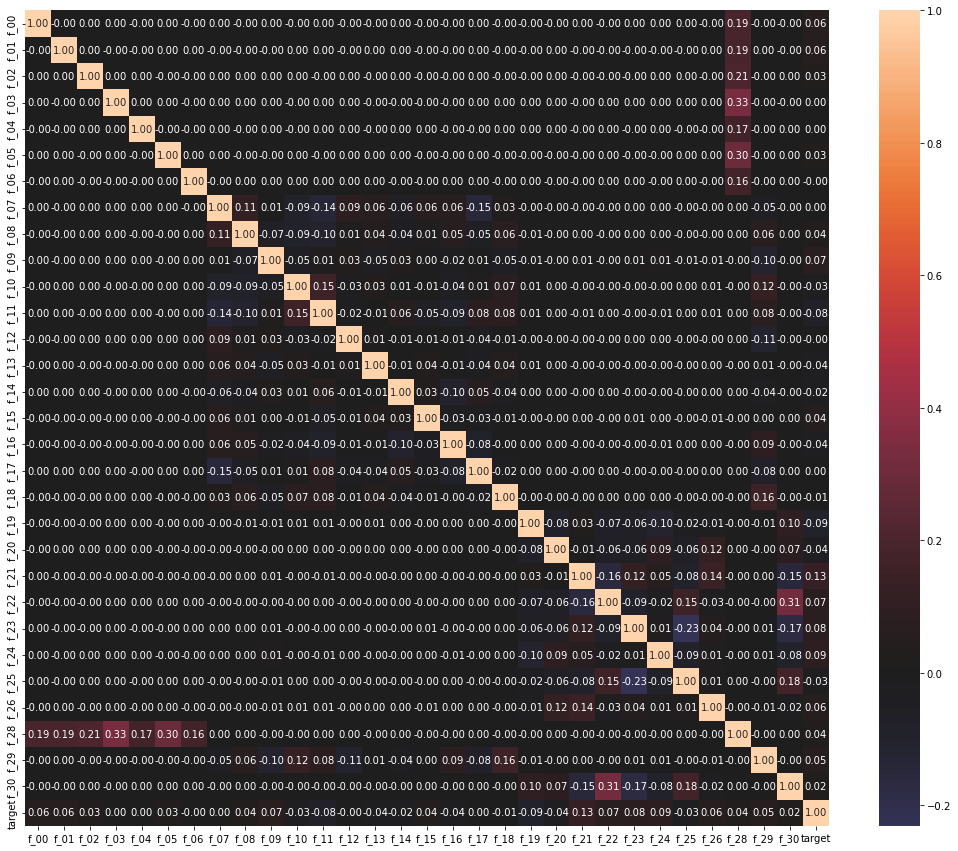

In [9]:
# Check correlations
plt.figure(figsize=(18, 15))
sns.heatmap(train.corr(), center=0, annot=True, fmt='.2f')

**Comments**: 
1) `f_00`-`f_06` are correlated to `f_28`, and there are some features correalted to `f_29` and `f_30`, but nothing signaficantly strong.The hightest correlation is **0.33** which is between `f_03` and `f_28`.<br>
2) `f_03`, `f_04`, `f_06`, `f_07`, `f_12`, and `f_17` are **not** correlated with the target. 

We should be reminded that correlation shows us ***linear*** relation between two features. So even if `f_03`, `f_04`, `f_06`, `f_07`, `f_12`, and `f_17` have `0` coefficient with `target`, there might be non-linear relations. Checking rolling mean (moving average) can be a good way to observe non-linear dependences. This will show us how target mean reacts as the feature value gets bigger. Let's check further below.

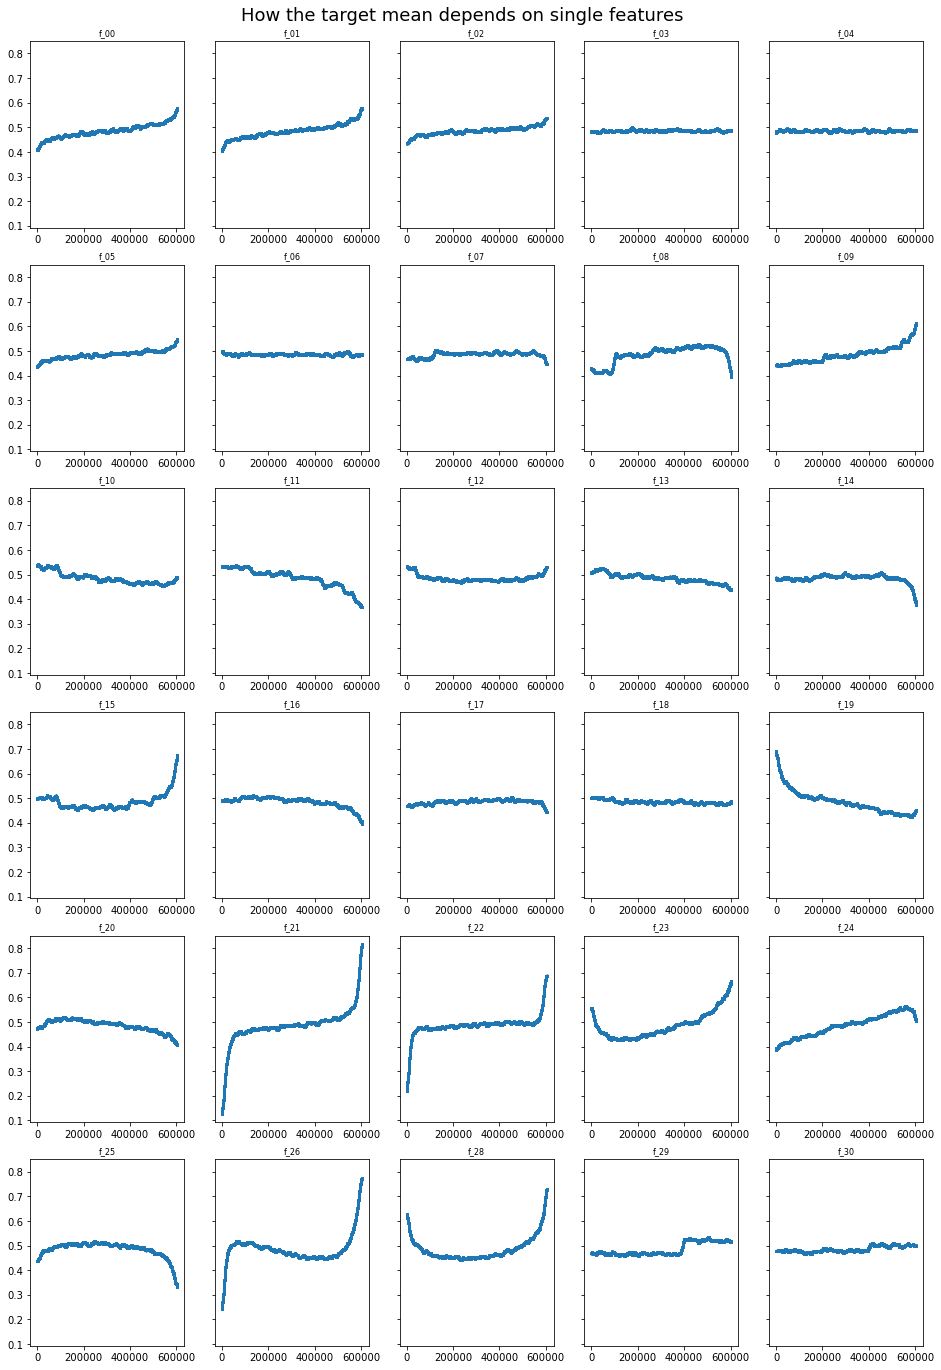

In [10]:
# Plot dependence between the target and the numeric features
def plot_single_features(df, features, ncols=5, title='title'):
                 
    nrows = (len(features) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows*4), sharey=True)

    for f, ax in zip(features, axs.ravel()):
        # dataframe with single feature and target
        temp = pd.concat([df[f], df['target']], axis=1)
        temp = temp.sort_values(f)  # sort in ascending order
        temp.reset_index(inplace=True)

        # Compute rolling mean
        rolling_mean = temp['target'].rolling(window=15000, min_periods=1, center=True).mean()

        # Plot
        ax.scatter(temp.index, rolling_mean, s=2)
        ax.set_title(f, fontsize=8)

    plt.suptitle(title, y=0.90, fontsize=18)
    plt.show()

plot_single_features(train, num_features, title='How the target mean depends on single features')

**Comment**: 
1. There are many nonlinear relationships. Linear classification will not be effective.
2. We can assume that the target is not dependent to `f_03`, `f_04`, `f_06`, `f_07`, `f_12`, and `f_17`.

### 2) Object Features

In [11]:
# Check number of unique values
train['f_27'].value_counts()

BBBBBBCJBC    9
ACBBAABABC    8
BCBBBBCLBC    8
BCBCAABKBB    8
BBBBBABLBD    8
             ..
AABBAACNCC    1
ACBBAACMDC    1
ABABAAHFBA    1
AABBBAAOFB    1
BBBBAAAGBC    1
Name: f_27, Length: 524944, dtype: int64

**Comments**: We cannot be certain that these string values are all the possible values. There might be a new combination of letter in validating/testing dataset. We should split each alphabet.

In [12]:
# Check length of the strings
max(train['f_27'].str.len().values), min(train['f_27'].str.len().values)

(10, 10)

In [13]:
# Return 'n'th character
def nth_char(column, n):
    count = 1
    nth = []
    for characters in column:
        for char in characters:
            if count == n:
                nth.append(char)
                count = 1
                break
            else:
                count += 1
    return nth

# Split into letters
def split_to_letter(df, col):
    store = []

    # Split the letters
    for i in range(1, 11):
        l = np.array(nth_char(df.loc[:, col], i))
        store.append(l)

    return pd.DataFrame({"f_27_01":store[0], "f_27_02":store[1], "f_27_03":store[2], 
                        "f_27_04":store[3], "f_27_05":store[4], "f_27_06":store[5], 
                        "f_27_07":store[6], "f_27_08":store[7], "f_27_09":store[8], 
                        "f_27_10":store[9]})

split_f27 = split_to_letter(train, "f_27")
split_f27.head()

,f_27_01,f_27_02,f_27_03,f_27_04,f_27_05,f_27_06,f_27_07,f_27_08,f_27_09,f_27_10
0,B,B,B,B,G,A,D,Q,B,D
1,B,B,B,C,A,B,C,S,D,D
2,B,F,A,D,A,B,G,B,D,D
3,A,C,B,C,D,A,E,Q,A,D
4,A,C,B,C,A,A,D,F,D,B


In [14]:
f27_target = pd.concat([split_f27, Ytr], axis=1)

# Check relation between each letter and target value
for i in range(10):
    letters = f27_target.iloc[:, i].unique()
    print('Position:', i+1)
    f27_count = []
    f27_mean = []
    for l in letters:
        f27_count.append(f27_target[f27_target.iloc[:, i]==l]['target'].count())
        f27_mean.append(round(f27_target[f27_target.iloc[:, i]==l]['target'].mean(), 3))

    zipped = list(zip(letters, f27_count, f27_mean))  # zip
    n_zipped = sorted(zipped)
    for l, c, m in n_zipped:
        print(l, ": count", c, ", mean", m)
    print()

Position: 1
A : count 302294 , mean 0.536
B : count 300706 , mean 0.436

Position: 2
A : count 97246 , mean 0.58
B : count 163879 , mean 0.483
C : count 151208 , mean 0.489
D : count 100625 , mean 0.452
E : count 52678 , mean 0.432
F : count 23819 , mean 0.414
G : count 9126 , mean 0.412
H : count 3085 , mean 0.404
I : count 945 , mean 0.404
J : count 287 , mean 0.376
K : count 79 , mean 0.405
L : count 18 , mean 0.278
M : count 3 , mean 0.667
N : count 2 , mean 1.0

Position: 3
A : count 199759 , mean 0.533
B : count 403241 , mean 0.463

Position: 4
A : count 107810 , mean 0.57
B : count 158955 , mean 0.484
C : count 140872 , mean 0.482
D : count 95973 , mean 0.448
E : count 54741 , mean 0.434
F : count 26522 , mean 0.442
G : count 11374 , mean 0.456
H : count 4362 , mean 0.47
I : count 1596 , mean 0.481
J : count 522 , mean 0.538
K : count 179 , mean 0.592
L : count 61 , mean 0.623
M : count 25 , mean 0.56
N : count 5 , mean 1.0
O : count 3 , mean 1.0

Position: 5
A : count 173989 , 

**Comments**: 
1. Position 1, 3, 6 are binary(A/B). We can represent this with 0/1.
2. Position 2, 4, 5, 7, 8, 9, 10 are **not** binary. We should numerize the alphabets in a different way.<br>

**Question**: Is there any relation between the combination of binary letters (in position 1, 3, 6) and target?

### - Check implication of the binary combinations

In [15]:
f27_AB = split_f27.loc[:, ['f_27_01', 'f_27_03', 'f_27_06']]
f27_AB = pd.concat([f27_AB, Ytr], axis=1)

# Make subsets
AAA = f27_AB.loc[(f27_AB['f_27_01']=='A') & (f27_AB['f_27_03']=='A') & (f27_AB['f_27_06']=='A'), :]
AAB = f27_AB.loc[(f27_AB['f_27_01']=='A') & (f27_AB['f_27_03']=='A') & (f27_AB['f_27_06']=='B'), :]
ABA = f27_AB.loc[(f27_AB['f_27_01']=='A') & (f27_AB['f_27_03']=='B') & (f27_AB['f_27_06']=='A'), :]
ABB = f27_AB.loc[(f27_AB['f_27_01']=='A') & (f27_AB['f_27_03']=='B') & (f27_AB['f_27_06']=='B'), :]
BAA = f27_AB.loc[(f27_AB['f_27_01']=='B') & (f27_AB['f_27_03']=='A') & (f27_AB['f_27_06']=='A'), :]
BAB = f27_AB.loc[(f27_AB['f_27_01']=='B') & (f27_AB['f_27_03']=='A') & (f27_AB['f_27_06']=='B'), :]
BBA = f27_AB.loc[(f27_AB['f_27_01']=='B') & (f27_AB['f_27_03']=='B') & (f27_AB['f_27_06']=='A'), :]
BBB = f27_AB.loc[(f27_AB['f_27_01']=='B') & (f27_AB['f_27_03']=='B') & (f27_AB['f_27_06']=='B'), :]

# Check relations
print("AAA: count", AAA.shape[0], ", mean", round(AAA['target'].mean(), 3))
print("AAB: count", AAB.shape[0], ", mean", round(AAB['target'].mean(), 3))
print("ABA: count", ABA.shape[0], ", mean", round(ABA['target'].mean(), 3))
print("ABB: count", ABB.shape[0], ", mean", round(ABB['target'].mean(), 3))
print("BAA: count", BAA.shape[0], ", mean", round(BAA['target'].mean(), 3))
print("BAB: count", BAB.shape[0], ", mean", round(BAB['target'].mean(), 3))
print("BBA: count", BBA.shape[0], ", mean", round(BBA['target'].mean(), 3))
print("BBB: count", BBB.shape[0], ", mean", round(BBB['target'].mean(), 3))

AAA: count 47875 , mean 0.548
AAB: count 53713 , mean 0.571
ABA: count 119268 , mean 0.491
ABB: count 81438 , mean 0.573
BAA: count 58033 , mean 0.462
BAB: count 40138 , mean 0.567
BBA: count 96181 , mean 0.403
BBB: count 106354 , mean 0.404


In [16]:
# How about total number of A and B?
A1B2 = pd.concat([ABB, BAB, BBA])
A2B1 = pd.concat([AAB, ABA, ABB])
A3 = AAA
B3 = BBB

# Check relations
print("A1B2: count", A1B2.shape[0], ", mean", round(A1B2['target'].mean(), 3))
print("A2B1: count", A2B1.shape[0], ", mean", round(A2B1['target'].mean(), 3))
print("A3: count", A3.shape[0], ", mean", round(A3['target'].mean(), 3))
print("B3: count", B3.shape[0], ", mean", round(B3['target'].mean(), 3))

A1B2: count 217757 , mean 0.496
A2B1: count 254419 , mean 0.534
A3: count 47875 , mean 0.548
B3: count 106354 , mean 0.404


In [ ]:
def num_As(c):
    n = 0
    for s in c:
        if s == 'A':
            n += 1
    return n

def num_Bs(c):
    n = 0
    for s in c:
        if s == 'B':
            n += 1
    return n

In [ ]:
f27_As = Xtr['f_27'].apply(num_As)
f27_As_target = pd.concat([f27_As, Ytr], axis=1)

f27_Bs = Xtr['f_27'].apply(num_Bs)
f27_Bs_target = pd.concat([f27_Bs, Ytr], axis=1)

# Check relations
for i in range(1, 11):
    print("%s A(s): count"%(i), f27_As_target.loc[f27_As_target['f_27'] == i, :].shape[0], 
    ", mean", round(f27_As_target.loc[f27_As_target['f_27'] == i, :]['target'].mean(), 3))
    print("%s B(s): count"%(i), f27_Bs_target.loc[f27_Bs_target['f_27'] == i, :].shape[0], 
    ", mean", round(f27_Bs_target.loc[f27_Bs_target['f_27'] == i, :]['target'].mean(), 3))

**Comments**: We can detect higher means in data with more A's.

### - Check the number of unique alphabets in the strings

In [17]:
def num_uniqe(c):
    ll = []
    for s in c:
        ll.append(s)
    return len(set(ll))

In [18]:
unique_f27 = Xtr['f_27'].apply(num_uniqe)
unique_f27_target = pd.concat([unique_f27, Ytr], axis=1)

# Check relations
for i in range(1, 11):
    print("%s unique letter(s): count"%(i), unique_f27_target.loc[unique_f27_target['f_27'] == i, :].shape[0], 
    ", mean", round(unique_f27_target.loc[unique_f27_target['f_27'] == i, :]['target'].mean(), 3))

1 unique letter(s): count 1 , mean 0.0
2 unique letter(s): count 723 , mean 0.087
3 unique letter(s): count 21441 , mean 0.085
4 unique letter(s): count 141372 , mean 0.482
5 unique letter(s): count 268031 , mean 0.489
6 unique letter(s): count 147986 , mean 0.479
7 unique letter(s): count 22648 , mean 0.911
8 unique letter(s): count 794 , mean 0.898
9 unique letter(s): count 4 , mean 1.0
10 unique letter(s): count 0 , mean nan


**Comments**: There are some relations bewteen the number of unique alphabets. We will include this feature to our dataset.

## 3. Preprocessing

We will numerize the split alphabets. Also, we will include the number of A's, B's, and the number of unique alphabets as one of the featuers. This should be done for all of training, validating and testing datasets.

In [19]:
def numerize_f27(c):
    return c.apply(ord) - ord('A')

### - Training dataset

In [20]:
# Numerize 'split_f27'
num_f27 = split_f27.apply(numerize_f27)

# Drop original 'f_27' column
Xtr = Xtr.drop(columns=['f_27'])

# Update
Xtr = pd.concat([Xtr, num_f27], axis=1)
Xtr['uniq_f27'] = unique_f27
Xtr.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,f_27_01,f_27_02,f_27_03,f_27_04,f_27_05,f_27_06,f_27_07,f_27_08,f_27_09,f_27_10,uniq_f27
0,-0.052250,0.298940,-0.294916,0.839824,0.492405,1.267292,-0.615136,4,2,2,1,1,2,2,1,0,2,3,0,5.236587,3.187739,0.834891,1.764693,1.731798,1.215476,0.542357,2.719219,53.501426,0,2,1,1,1,1,6,0,3,16,1,3,5
1,-0.012211,-0.031523,-0.369406,-1.135423,1.634742,0.115882,0.678123,5,0,3,1,5,5,3,0,2,3,3,2,0.527311,0.498142,-4.203678,2.785775,-5.381873,-0.850487,4.615838,-2.110356,-221.302158,0,2,1,1,1,2,0,1,2,18,3,3,5
2,0.936412,0.237754,0.337034,0.268397,0.523153,1.005929,1.142934,4,4,2,0,0,4,3,2,1,5,3,0,1.504620,0.153650,5.121259,2.543896,3.005761,-1.478409,2.554633,6.268951,264.616875,0,1,1,5,0,3,0,1,6,1,3,3,5
3,1.092694,-1.979627,1.198166,-1.232843,0.418094,-1.280633,-0.954678,1,1,1,0,0,7,4,2,1,1,4,1,-1.783147,-3.651592,-1.418506,-1.368090,1.907296,-3.372114,3.143169,-0.887248,-219.346013,1,0,0,2,1,2,3,0,4,16,0,3,6
4,0.853603,-0.226541,-0.647903,-1.333107,1.695221,-0.284688,0.469856,1,2,5,0,3,1,2,1,5,1,4,2,-1.575326,5.500917,-3.601073,-3.032338,0.407618,3.311743,3.444788,-0.904312,-133.783929,0,2,0,2,1,2,0,0,3,5,3,1,5


### - Validating dataset

In [21]:
# Numerize alphabets
split_f27_va = split_to_letter(Xva, "f_27")
num_f27_va = split_f27_va.apply(numerize_f27)

# Number of unique alphabets
unique_f27_va = Xva['f_27'].apply(num_uniqe)

# Drop original 'f_27' column
Xva = Xva.drop(columns=['f_27'])

# Update
Xva = pd.concat([Xva, num_f27_va], axis=1)
Xva['uniq_f27'] = unique_f27_va
Xva.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,f_27_01,f_27_02,f_27_03,f_27_04,f_27_05,f_27_06,f_27_07,f_27_08,f_27_09,f_27_10,uniq_f27
0,0.194491,1.180926,-1.474570,-1.969979,-0.632224,-0.908537,-0.929414,3,0,2,1,1,3,4,4,3,4,1,1,2.111813,0.367228,5.540808,0.566451,-3.640977,-3.134273,4.232714,1.411271,-380.668584,0,1,1,1,0,0,1,0,2,8,5,1,5
1,0.073512,1.215182,1.887183,0.664100,1.445916,0.407144,-0.965463,1,0,2,1,1,4,3,1,3,1,5,1,-0.892378,0.044843,-0.562313,1.033356,3.351333,-1.598481,-1.585360,-0.413281,602.721455,0,0,0,0,1,1,1,1,3,7,2,2,5
2,0.990606,1.390944,0.765208,-0.204159,-0.265682,0.051791,2.526925,6,4,5,1,3,4,2,0,0,4,3,0,6.930342,-3.426247,1.094242,-3.755136,1.450646,7.071502,1.467113,2.519946,451.547357,0,0,1,4,1,1,1,0,0,11,2,1,5
3,0.621236,-1.282787,0.836890,1.208417,-0.212496,-1.729244,-0.741488,3,1,2,1,4,0,2,0,0,3,2,6,0.394603,-1.145438,0.222260,5.028227,-1.303147,-3.905412,2.162827,-1.369400,-193.028625,1,1,0,3,1,1,1,1,3,13,2,4,6
4,-0.143469,0.952492,-0.146993,0.362883,-0.105120,-1.208656,-1.317498,2,1,0,1,3,0,2,1,2,1,1,3,0.040083,-1.206330,-5.391257,-0.667532,-0.731155,3.807904,-1.748775,1.013688,50.602827,1,0,0,1,0,2,0,0,5,0,2,4,5


### - Testing dataset

In [22]:
# Numerize alphabets
split_f27_te = split_to_letter(Xte, "f_27")
num_f27_te = split_f27_te.apply(numerize_f27)

# Number of unique alphabets
unique_f27_te = Xte['f_27'].apply(num_uniqe)

# Drop original 'f_27' column
Xte = Xte.drop(columns=['f_27'])

# Concat
Xte = pd.concat([Xte, num_f27_te], axis=1)
Xte['uniq_f27'] = unique_f27_te
Xte.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,f_27_01,f_27_02,f_27_03,f_27_04,f_27_05,f_27_06,f_27_07,f_27_08,f_27_09,f_27_10,uniq_f27
0,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,0,0,5,1,1,2,2,0,1,-1.128371,2.749347,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,99.478419,0,0,1,0,0,0,1,0,3,11,0,2,5
1,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,0,2,1,3,0,0,0,2,0,-4.424098,1.080762,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,-65.993825,1,0,0,5,0,1,1,0,4,6,2,1,6
2,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,4,1,1,3,2,2,4,1,0,3,-1.523864,-1.406712,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,-87.405622,0,1,1,1,0,2,0,1,1,10,4,4,5
3,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,4,2,1,5,0,3,3,1,4,2,-1.404597,3.011085,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,-281.293460,0,0,0,4,1,4,0,0,2,16,2,2,5
4,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,2,0,0,3,0,1,2,0,2,2,-1.968516,0.100594,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,25.629415,0,2,0,4,1,1,1,1,3,0,1,5,5


In [23]:
Xtr.shape, Xva.shape, Xte.shape

((603000, 41), (297000, 41), (700000, 41))

## 4. Model Application

In [24]:
# Fit
lgbm_model =LGBMClassifier(n_estimators=5000, min_child_samples=80, random_state=1307)
lgbm_model.fit(Xtr.values, Ytr)

# Predict
Yva_pred = lgbm_model.predict_proba(Xva.values)[:,1]

# Compute score
score = roc_auc_score(Yva, Yva_pred)
print(f"Validation AUC:{(score):.3f}")

Validation AUC:0.991


### - Apply to the Testing dataset

In [25]:
# Predict
Yte_pred = lgbm_model.predict_proba(Xte.values)[:,1]

# Convert to pandas Series
Yte_pred = pd.Series(Yte_pred)

# Add 'id'
Yte_pred = pd.concat([test_id, Yte_pred], axis=1)
Yte_pred = Yte_pred.rename(columns={0: "target"})

# Create csv file
submit_may = Yte_pred.to_csv('submission.csv', index=False) # score : 0.99039

## 5. What next?

### - Further Investigation

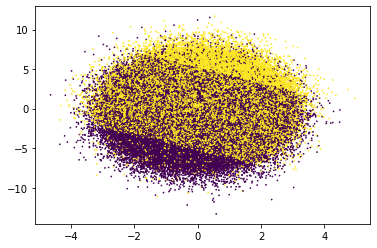

In [ ]:
# interactions between features
f_02 = Xtr["f_02"]
f_21 = Xtr["f_21"]
hue = Ytr

plt.scatter(f_02, f_21, s=0.5, c = hue)

**Comments**: The correlation of `f_02` and `f_21` is zero. Still, we can observe some 'interaction' between these two features.